## I&I

In [5]:
import pandas as pd
import numpy as np
import glob
from collections import Counter
from datetime import datetime
from matplotlib import pyplot as plt
import seaborn as sb

from sklearn.metrics import confusion_matrix
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
% matplotlib inline
import warnings
warnings.filterwarnings("ignore")

In [6]:
cd data

[Errno 2] No such file or directory: 'data'
/home/shgidi/nbs/RoadTrackACC/data


In [7]:
f=glob.glob('*.xlsx')
f

['Acc_Data_Toyota_2604.xlsx',
 'Acc_Test1704.xlsx',
 'Acc_Test_240418.xlsx',
 'CarExp_AccData_2202.xlsx']

In [9]:
# categroies
categories={0:'regular',1:'standstill',2:'zigzag',3:'dirt',4:'bumper',5:'stop'}

In [10]:
# put all sheets here
# ['Acc_Data_Toyota_2604.xlsx',
#  'Acc_Test1704.xlsx',
#  'Acc_Test_240418.xlsx']
category_dict = {'REGULAR DRIVE':0,'Standingstill':1,'Driving':0,'Drive':0,  'Drive_2':0, 'Bumper_Low':4,
                 'Bumper_High':4,   'Bumper_High_2':4,'Bumpers':4,'ZigZag':2,'ZigZag_2':2,'Emergency_stop':4,
                'Dirty_Road':3, 'Dirty_Road_2':3, 'Small_Bumper':4,'Emergency_Stop':5   ,'Emergency_Stop_2':5   ,'Reg_Driving1':0
                ,'Bumper_Low_Speed':4 ,'Reg_Driving2':0 ,'Hard_Stop':5,'Bumpers':4 ,'DirtyRoad':3 ,'ZigZag1':2
                ,'ZigZag2':2,'ZigZag3':2}

['Acc_Data_Toyota_2604.xlsx']
REGULAR DRIVE
Bumpers
ZigZag
Emergency_stop
Dirty_Road
Small_Bumper
['Acc_Test_240418.xlsx']
Reg_Driving1
Bumper_Low_Speed
Reg_Driving2
Hard_Stop
Bumpers
DirtyRoad
ZigZag1
ZigZag2
ZigZag3


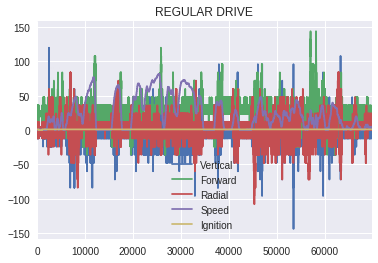

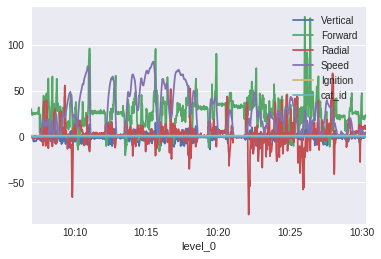

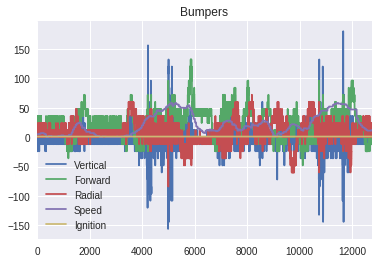

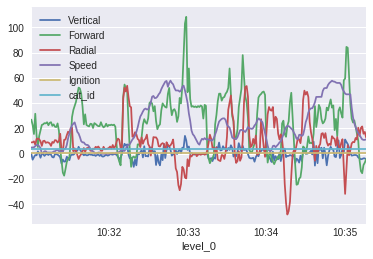

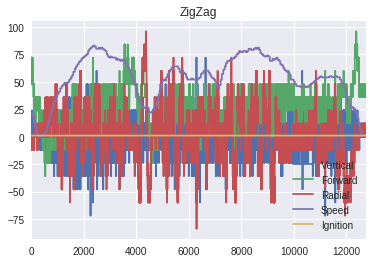

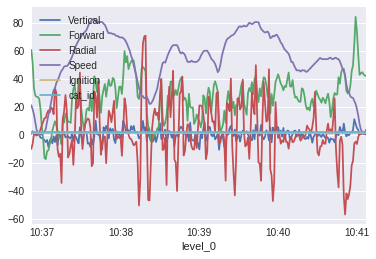

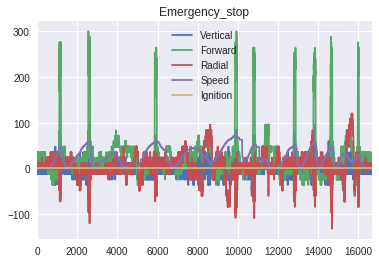

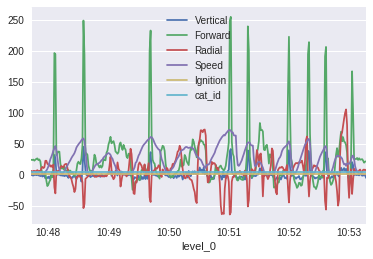

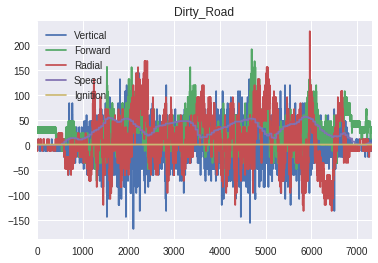

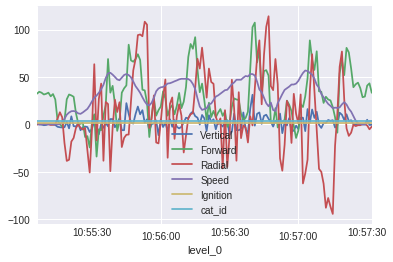

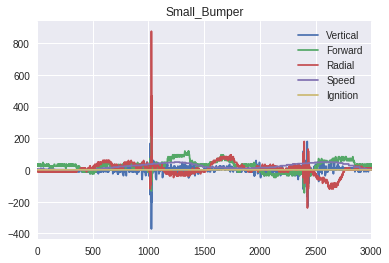

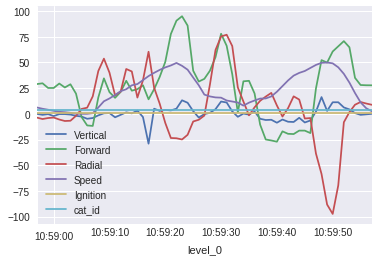

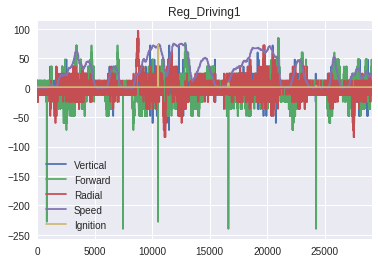

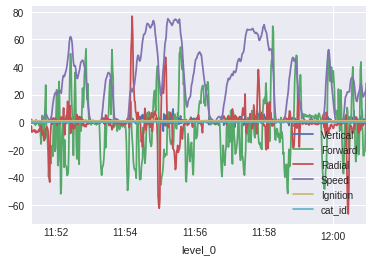

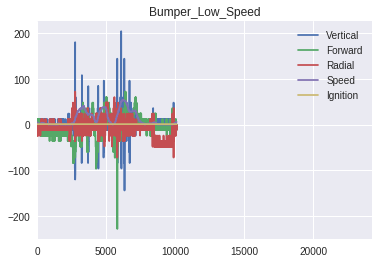

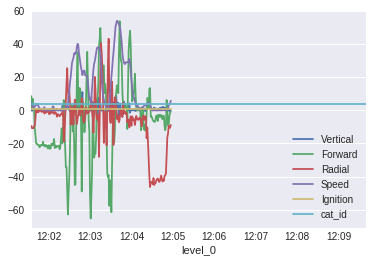

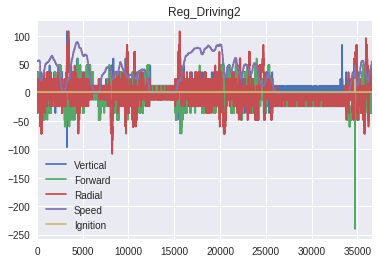

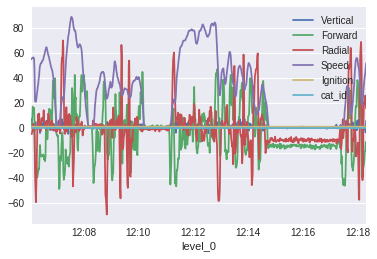

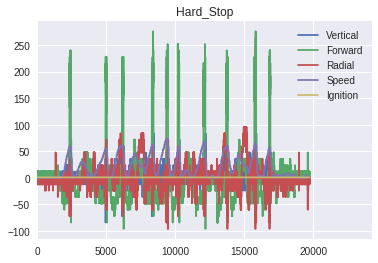

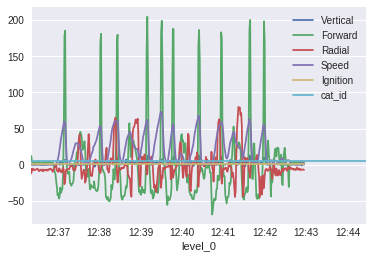

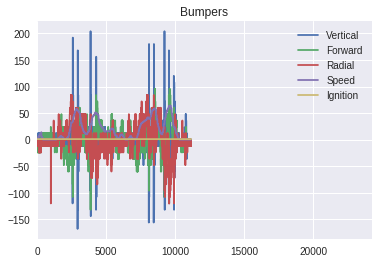

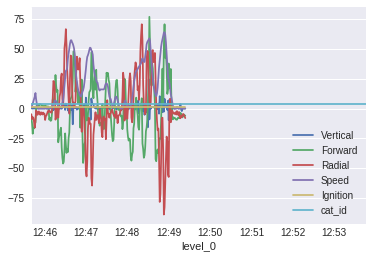

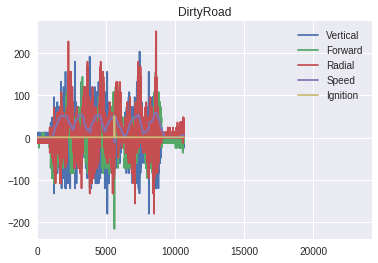

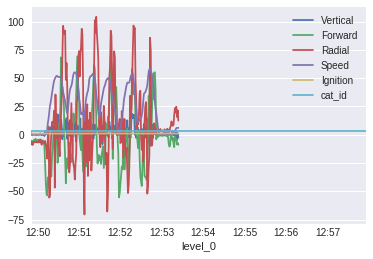

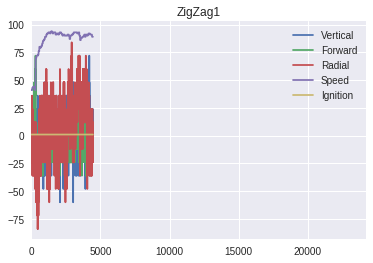

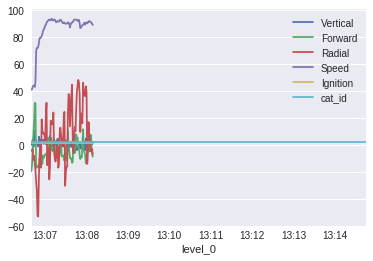

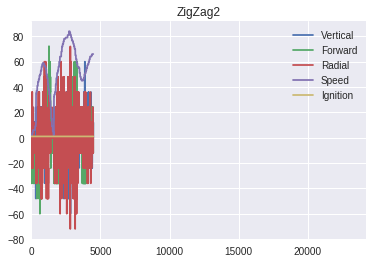

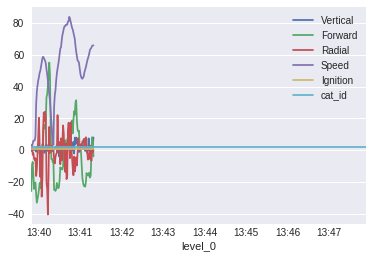

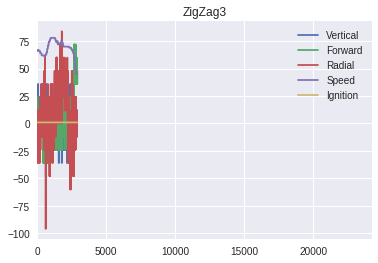

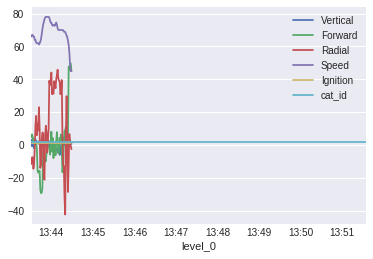

In [13]:
# load multiple files

df_list=[]
df_dict={}
big_df=pd.DataFrame()

for file_id in ['Acc_Data_Toyota_2604.xlsx','Acc_Test_240418.xlsx']:
    print([file_id])

    excel=pd.ExcelFile(file_id)
    hz=50 if file_id!=1 else 100

    features=['Vertical','Forward','Radial','Speed','Ignition','level_0']
    numeric_features=['Vertical','Forward','Speed','Radial']

    for i,name in enumerate(excel.sheet_names):
        df = excel.parse(name,header=1)
        df = df.reset_index()
        df.columns=[column.replace(' ','') for column in df.columns]
        df[numeric_features] = df[numeric_features].apply(pd.to_numeric, errors='coerce')
        df = df[features]#
        df.Vertical = df.Vertical + 240 # normalize" weritcal Axis
        
        start = pd.Timestamp(df['level_0'][0].replace(']','')) # "resample" time
        end = start+ pd.Timedelta(milliseconds=1000/hz*len(df))
        t = np.linspace(start.value, end.value, len(df))
        t = pd.to_datetime(t)
        df['level_0'] = t
        ax = df.plot(title=name)

        df = df.set_index(df['level_0']) # add more columns
        df['file'] = file_id
        df['sheet'] = name
        df['cat_id'] = category_dict[name]
        print(name)
                
        big_df=big_df.append(df) # put it all in big_df
        df_list.append(df)
        df.resample('s').mean().plot() # resample by the second

## Parse

In [104]:
big_df.level_0 = big_df.index.round('s')

In [105]:
big_df=big_df.dropna()

In [106]:
anot.keys()

Index(['file', 'sheet', 'event', 'start time', 'end time', 'start row',
       'end row'],
      dtype='object')

In [117]:
# read annotation file

f = glob.glob('*.csv')

anot={}

anot = pd.read_csv(f[0])

    
hard_stops = anot[anot.event=='hard_stop']
# fit date time format. first workout hard stops
hard_stops['start time']=pd.to_datetime(hard_stops['start time'])
hard_stops['end time']=pd.to_datetime(hard_stops['end time'])


In [118]:
hard_stops

,file,sheet,event,start time,end time,start row,end row
12,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:37:18,2018-05-02 12:37:25,2356.0,3310.0
13,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:38:10,2018-05-02 12:38:16,5640.0,6525.0
14,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:38:33,2018-05-02 12:38:40,7449.0,8508.0
15,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:38:50,2018-05-02 12:38:52,9034.0,9264.0
16,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:38:56,2018-05-02 12:38:59,9462.0,9802.0
17,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:39:05,2018-05-02 12:39:07,10096.0,10480.0
18,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:39:16,2018-05-02 12:39:23,10908.0,11966.0
19,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:39:35,2018-05-02 12:39:43,12565.0,13709.0
20,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:39:52,2018-05-02 12:40:00,14196.0,15271.0
21,acc_data_2404018.xlsx,Hard_Stop,hard_stop,2018-05-02 12:40:18,2018-05-02 12:40:19,16257.0,16423.0


In [127]:
# important! make a list of hard stops
import datetime

hard_stop_list=[]
for row in hard_stops.iterrows():
    i=0
    time=row[1]['start time']
    while time >= row[1]['start time'] and time<=row[1]['end time']:
        hard_stop_list.append(time)
        time=row[1]['start time']+datetime.timedelta(0,i) 
        i+=1

In [128]:
len(hard_stop_list)

201

In [129]:
# set hard stops annotations
big_df['hard_stop_on']=0
big_df['hard_stop_on']\
[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df.level_0.isin(hard_stop_list))]=1

In [136]:
(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df.level_0.isin(hard_stop_list))

level_0
2018-05-01 10:07:00.964000000    False
2018-05-01 10:07:00.984000256    False
2018-05-01 10:07:01.004000512    False
2018-05-01 10:07:01.024000768    False
2018-05-01 10:07:01.044001024    False
2018-05-01 10:07:01.064001536    False
2018-05-01 10:07:01.084001792    False
2018-05-01 10:07:01.104002048    False
2018-05-01 10:07:01.124002304    False
2018-05-01 10:07:01.144002560    False
2018-05-01 10:07:01.164002816    False
2018-05-01 10:07:01.184003072    False
2018-05-01 10:07:01.204003328    False
2018-05-01 10:07:01.224003840    False
2018-05-01 10:07:01.244004096    False
2018-05-01 10:07:01.264004352    False
2018-05-01 10:07:01.284004608    False
2018-05-01 10:07:01.324005120    False
2018-05-01 10:07:01.344005376    False
2018-05-01 10:07:01.364005632    False
2018-05-01 10:07:01.384006144    False
2018-05-01 10:07:01.404006400    False
2018-05-01 10:07:01.424006656    False
2018-05-01 10:07:01.444006912    False
2018-05-01 10:07:01.464007168    False
2018-05-01 10:07:

In [130]:
len(big_df) #438921
len(big_df[big_df['cat_id']==5]) #28,264

19733

In [131]:
for df in df_list:
    if max(df.cat_id)==5: #hard stopprint
        print(max(df.cat))
        plt.show()
        df.Speed.plot()

AttributeError: 'DataFrame' object has no attribute 'cat'

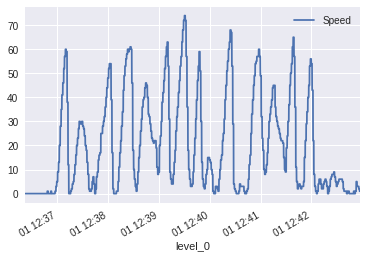

In [132]:
big_df[big_df['cat_id']==5].dropna()[['Speed']].plot()

In [133]:
# extract features
features=['Vertical','Radial','Forward','Speed']
research_dfa = big_df.groupby('level_0')[features].mean()\
    .join(big_df.groupby('level_0')[features].std(), rsuffix='_std')\
    .join(big_df.groupby('level_0')[features].max(), rsuffix='_max')\
    .join(big_df.groupby('level_0')[features].min(), rsuffix='_min')\
    .join(big_df.groupby('level_0')['cat_id'].max())\
    .join(big_df.groupby('level_0')['hard_stop_on'].max())

In [134]:
research_dfas=research_dfa.shift().join(research_dfa,lsuffix='l')#.dropna()

In [135]:
sum(research_dfa.hard_stop_on)

0

In [126]:
trn,test = train_test_split(research_dfa[research_dfas.cat_id<4])
len(trn), len(test)

(2677, 893)

In [96]:
models = [LogisticRegression(),svm.SVC(decision_function_shape='ovo'),\
          MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(15, 10), random_state=1)]

for model in models:
    # SVM is much slower
    model.fit(trn[features],trn['cat_id'])
    print(model.score(test[features],test[['cat_id']]))

0.791713325868
0.765957446809
0.799552071669


In [98]:
trn,test = train_test_split(research_dfas)

In [101]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(50, 50), random_state=1)

clf.fit(trn[features],trn['hard_stop_on'])  
clf.score(test[features],test['hard_stop_on'])

0.9778129952456418

In [102]:
cm = confusion_matrix(np.array(clf.predict_proba(test[features])>0.1)[:,1], test[['hard_stop_on']])
cm

array([[1156,   15],
       [  79,   12]])

## Plots

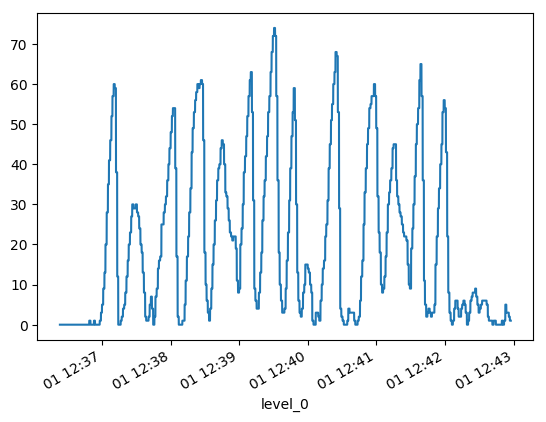

In [256]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed'].plot()

In [324]:
# ad ma column
big_df['speed_ma_100']\
=pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed'],100).fillna(0)

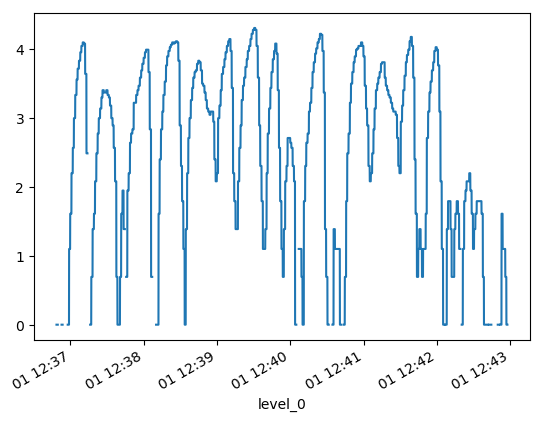

In [258]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed'].apply(lambda x:np.log(np.abs(x))).plot()

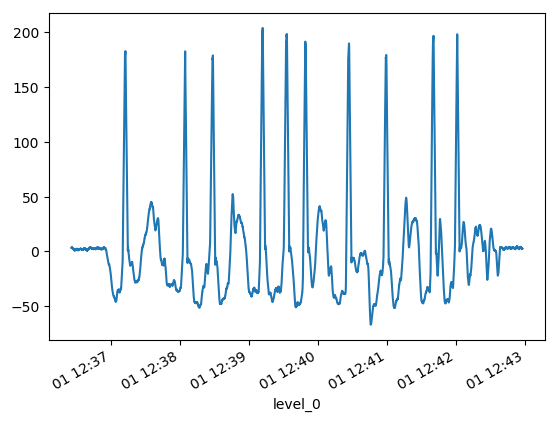

In [225]:
pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'],100).plot()

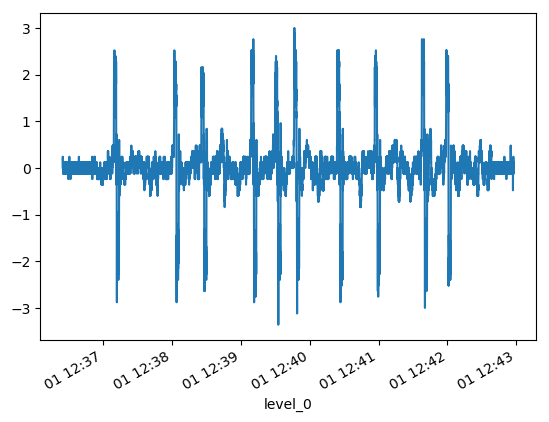

In [236]:
pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'],100).diff().plot()

In [241]:
sum(pd.rolling_mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'],100).diff()>1)

1010

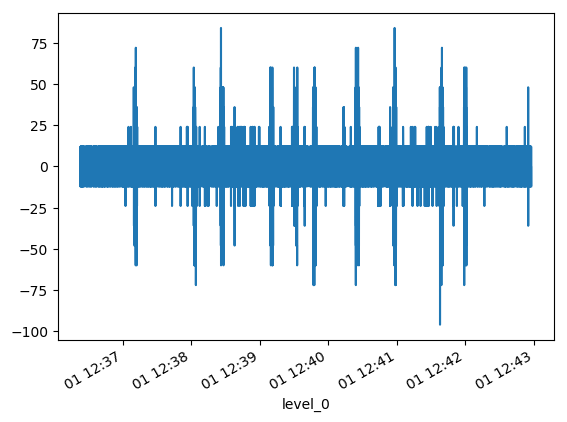

In [237]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'].diff().plot()

In [239]:
sum(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Forward'].diff()>50)

22

### Annotate stops

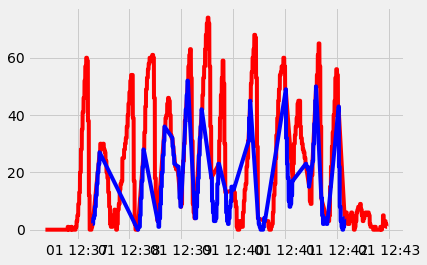

In [200]:

plt.plot(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df['hard_stop_on']==0)]['Speed'], color='r')
plt.plot(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df['hard_stop_on']==1)]['Speed'], color='b')
plt.show()

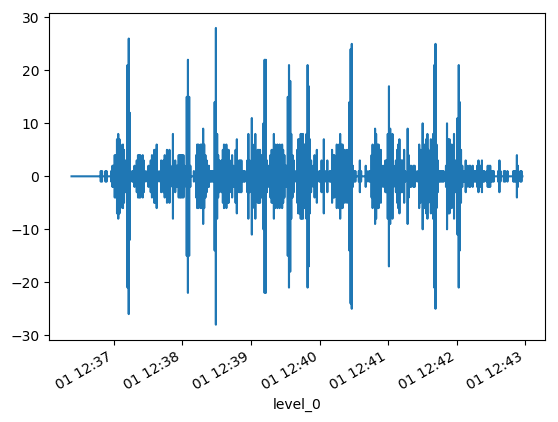

In [221]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)].Speed.diff().diff().plot()

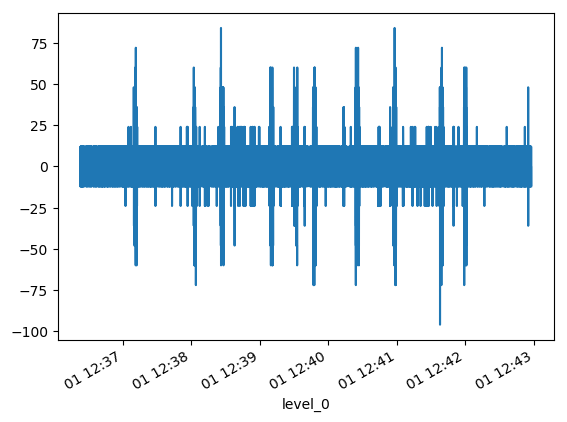

In [234]:
big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)].Forward.diff().plot()

In [187]:
len(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)].isna())

24236

In [93]:
# move to sql to tag hardstops correctly
#or generate another table

In [130]:
import datetime
hard_stops['start time'].iloc[0]+ datetime.timedelta(0,1) 

Timestamp('2018-05-01 12:37:18')

In [215]:
np.mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)&(big_df['hard_stop_on']==1)]['Speed'])

14.284299858557285

In [224]:
np.mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df['hard_stop_on']==0)]['Speed'])

29.64387046907457

In [223]:
np.mean(big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df['hard_stop_on']==1)]['Speed'].diff())

0.0004042037186742118

In [287]:
speed=big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]['Speed']

In [274]:
big_df['speed_diff'] = big_df['Speed'] - big_df['Speed'].shift()  

In [275]:
big_df['speed_diff_1']=big_df['speed_diff'] .shift(1)

## Time series statistcs

In [ ]:
# takes some time
# Examine join distribution
sb.jointplot('speed_diff_1', 'speed_diff', big_df, kind='reg', size=4)

In [278]:
# test auto correlcation
# takes some time
from statsmodels.tsa.stattools import acf  
from statsmodels.tsa.stattools import pacf
lag_correlations = acf(big_df['speed_diff'].iloc[1:])  
lag_partial_correlations = pacf(big_df['speed_diff'].iloc[1:])

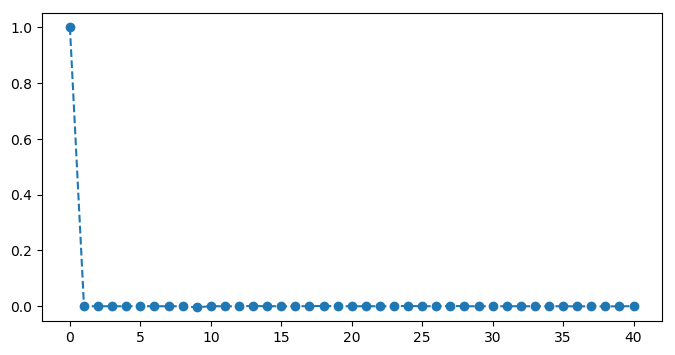

In [282]:
fig, ax = plt.subplots(figsize=(8,4))  
ax.plot(lag_correlations, marker='o', linestyle='--')

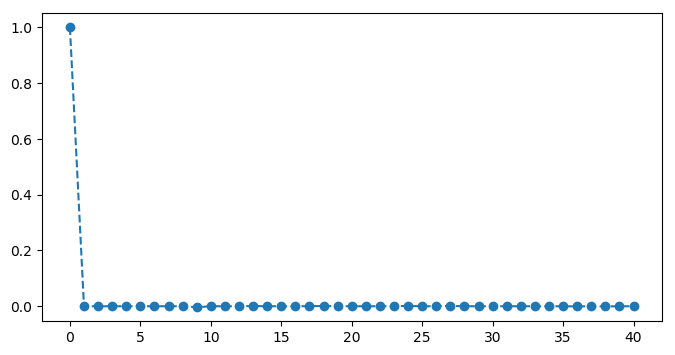

In [284]:
fig, ax = plt.subplots(figsize=(8,4))  
ax.plot(lag_partial_correlations, marker='o', linestyle='--')

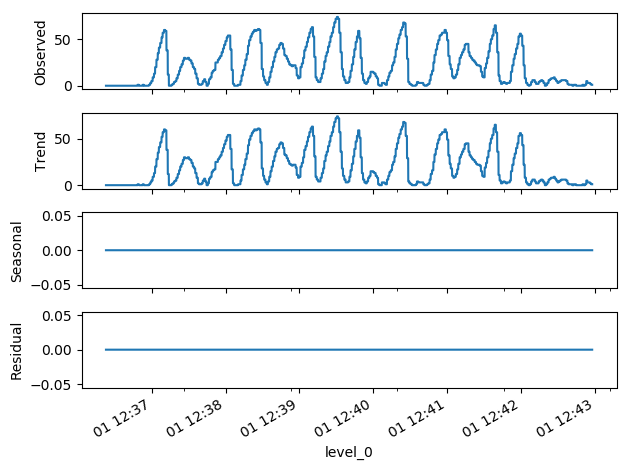

In [290]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(speed, model='additive', freq=1)  
fig = plt.figure()  
fig = decomposition.plot()

In [326]:
model

In [329]:
results.fittedvalues[300:320]

level_0
2018-05-01 12:36:28.946249216    0.000139
2018-05-01 12:36:28.966249984    0.000139
2018-05-01 12:36:28.986250752    0.000139
2018-05-01 12:36:29.006251520    0.000139
2018-05-01 12:36:29.026252288    0.000139
2018-05-01 12:36:29.046253312    0.000139
2018-05-01 12:36:29.066254080    0.000139
2018-05-01 12:36:29.086254848    0.000139
2018-05-01 12:36:29.106255616    0.000139
2018-05-01 12:36:29.126256640    0.000139
2018-05-01 12:36:29.146257408    0.000139
2018-05-01 12:36:29.166258176    0.000139
2018-05-01 12:36:29.186258944    0.000139
2018-05-01 12:36:29.206259712    0.000139
2018-05-01 12:36:29.226260736    0.000139
2018-05-01 12:36:29.246261504    0.000139
2018-05-01 12:36:29.266262272    0.000139
2018-05-01 12:36:29.286263040    0.000139
2018-05-01 12:36:29.306264064    0.000139
2018-05-01 12:36:29.326264832    0.000139
dtype: float64

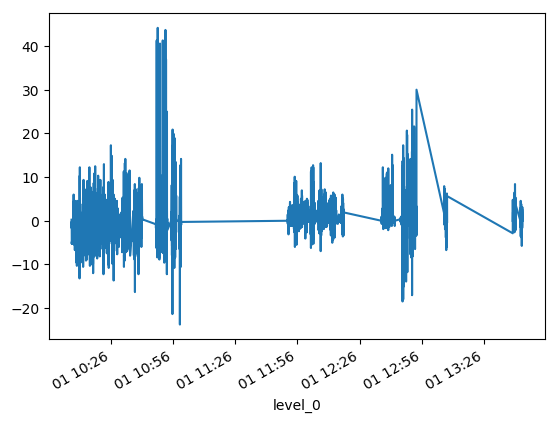

In [334]:
research_dfa.Vertical.iloc[1:].plot()

In [336]:
big_df.keys()

Index(['Vertical', 'Forward', 'Radial', 'Speed', 'Ignition', 'level_0', 'file',
       'sheet', 'cat_id', 'hard_stop_on', 'speed_diff', 'speed_diff_1',
       'speed_ma_100'],
      dtype='object')

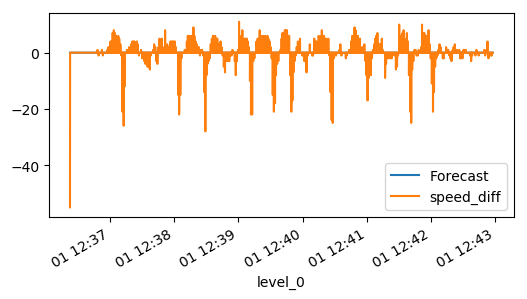

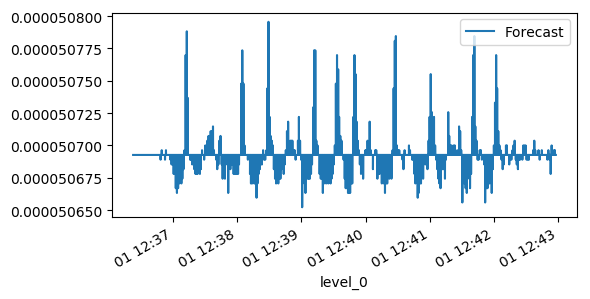

In [341]:
import statsmodels.api as sm 

data=big_df[(big_df['file']=='Acc_Test_240418.xlsx')&(big_df.cat_id==5)]
model = sm.tsa.ARIMA(data['speed_diff'].iloc[1:], order=(1, 0, 0))  
results = model.fit(disp=-1)  

data['Forecast'] = results.fittedvalues  
data[['Forecast','speed_diff']].plot(figsize=(6, 3))
data[['Forecast']].plot(figsize=(6, 3))

In [342]:
big_df.head()

,Vertical,Forward,Radial,Speed,Ignition,level_0,file,sheet,cat_id,hard_stop_on,speed_diff,speed_diff_1,speed_ma_100
level_0,,,,,,,,,,,,,
2018-05-01 10:07:00.964000000,0.0,24.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,NaN,NaN,NaN
2018-05-01 10:07:00.984000256,0.0,36.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,NaN,NaN
2018-05-01 10:07:01.004000512,0.0,36.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN
2018-05-01 10:07:01.024000768,0.0,24.0,0.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN
2018-05-01 10:07:01.044001024,0.0,24.0,-12.0,1.0,1.0,2018-05-01 10:07:01,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN


## Flatten bigDF

In [345]:
start = big_df['level_0'][0]
end = start+ pd.Timedelta(milliseconds=1000/hz*len(big_df))
t = np.linspace(start.value, end.value, len(big_df))
t = pd.to_datetime(t)

In [365]:
big_df['time_sec']=big_df.level_0
del big_df['level_0']

In [366]:
big_df=big_df.reset_index()
big_df=big_df.set_index('flat_time')


In [ ]:
def uniqueish_color():
    """There're better ways to generate unique colors, but this isn't awful."""
    return plt.cm.gist_ncar(np.random.random())
    #return np.random.choice(['r','g','b','y','c'])#plt.cm.gist_ncar(np.random.random())

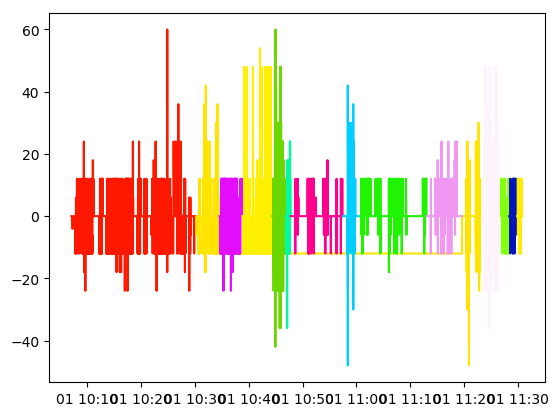

In [414]:

fig, ax = plt.subplots()
for i in big_df.sheet.unique():
    # Bumpers is duplicate
    color=uniqueish_color()
    #ax.plot(big_df[big_df.sheet==i].index, big_df[big_df.sheet==i]['Vertical'], color=color)
    ax.plot(big_df[big_df.sheet==i].index, pd.rolling_median(big_df[big_df.sheet==i]['Vertical'],30), color=color)
plt.show()

In [416]:
big_df.head()

,Vertical,Forward,Radial,Speed,Ignition,file,sheet,cat_id,hard_stop_on,speed_diff,speed_diff_1,speed_ma_100,time_sec
flat_time,,,,,,,,,,,,,
2018-05-01 10:07:01.000000000,0.0,24.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,NaN,NaN,NaN,2018-05-01 10:07:00.964000000
2018-05-01 10:07:01.020000000,0.0,36.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,NaN,NaN,2018-05-01 10:07:00.984000256
2018-05-01 10:07:01.040000256,0.0,36.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN,2018-05-01 10:07:01.004000512
2018-05-01 10:07:01.060000256,0.0,24.0,0.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN,2018-05-01 10:07:01.024000768
2018-05-01 10:07:01.080000256,0.0,24.0,-12.0,1.0,1.0,Acc_Data_Toyota_2604.xlsx,REGULAR DRIVE,0,0,0.0,0.0,NaN,2018-05-01 10:07:01.044001024


In [421]:
research_dfa.keys()

Index(['Vertical', 'Radial', 'Forward', 'Vertical_std', 'Radial_std',
       'Forward_std', 'Vertical_max', 'Radial_max', 'Forward_max',
       'Vertical_min', 'Radial_min', 'Forward_min', 'cat_id', 'hard_stop_on'],
      dtype='object')

In [437]:
big_df['flat_time']=t
big_df['flat_time_sec']=big_df['flat_time'].dt.round('s')

In [441]:
# making the research dfa - second based 
research_dfa=big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].mean()\
    .join(big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].std(), rsuffix='_std')\
    .join(big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].max(), rsuffix='_max')\
    .join(big_df.groupby('flat_time_sec')['Vertical','Radial','Forward'].min(), rsuffix='_min')\
    .join(big_df.groupby('flat_time_sec')['cat_id'].max())\
    .join(big_df.groupby('flat_time_sec')['hard_stop_on'].max())\
     .join(big_df.groupby('flat_time_sec')['sheet'].max())

### some more plots

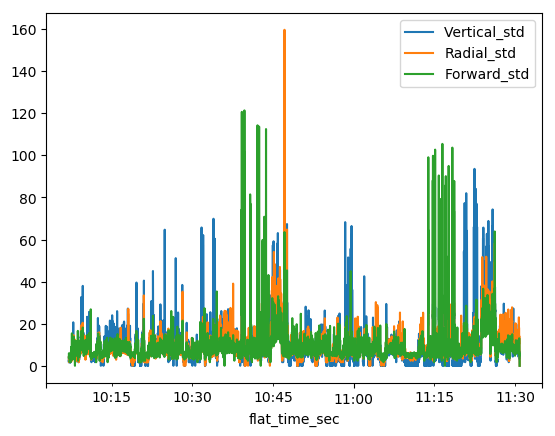

In [439]:
research_dfa[['Vertical_std','Radial_std','Forward_std']].plot()

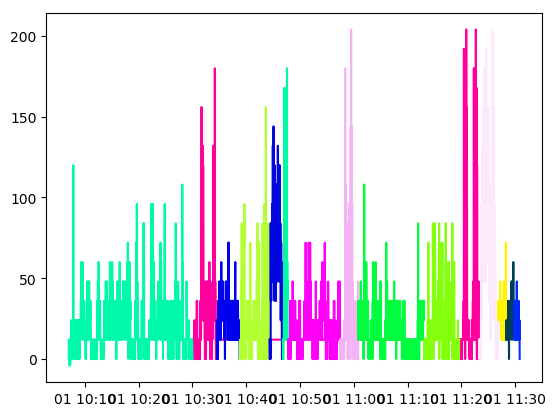

In [450]:
fig, ax = plt.subplots()
for i in big_df.sheet.unique():
    # Bumpers is duplicate
    color=uniqueish_color()
    #ax.plot(big_df[big_df.sheet==i].index, big_df[big_df.sheet==i]['Vertical'], color=color)
    ax.plot(research_dfa[research_dfa.sheet==i].index, \
            research_dfa[research_dfa.sheet==i]['Vertical'], color=color)

plt.show()

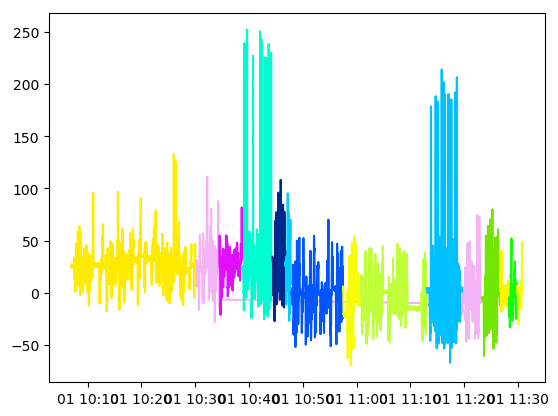

In [449]:
fig, ax = plt.subplots()
for i in big_df.sheet.unique():
    # Bumpers is duplicate
    color=uniqueish_color()
    #ax.plot(big_df[big_df.sheet==i].index, big_df[big_df.sheet==i]['Vertical'], color=color)
    ax.plot(research_dfa[research_dfa.sheet==i].index, \
            research_dfa[research_dfa.sheet==i]['Forward'], color=color)

plt.show()

## More

In [454]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import svm

In [455]:
trn,test = train_test_split(research_dfa)
len(trn), len(test)

(3772, 1258)

In [456]:
len(research_dfa),sum(research_dfa.hard_stop_on==1)

(5030, 115)

In [459]:
research_dfa.keys()

Index(['Vertical', 'Radial', 'Forward', 'Vertical_std', 'Radial_std',
       'Forward_std', 'Vertical_max', 'Radial_max', 'Forward_max',
       'Vertical_min', 'Radial_min', 'Forward_min', 'cat_id', 'hard_stop_on',
       'sheet'],
      dtype='object')

In [460]:
predictive_features=['Vertical', 'Radial', 'Forward', 'Vertical_std', 'Radial_std',\
       'Forward_std', 'Vertical_max', 'Radial_max', 'Forward_max',\
       'Vertical_min', 'Radial_min', 'Forward_min']

In [468]:
models=[LogisticRegression(),svm.SVC(decision_function_shape='ovo')]
for model in models:
    # SVM is much slower
    model.fit(trn[predictive_features],trn['hard_stop_on'])
    print(model.score(test[predictive_features],test[['hard_stop_on']]))

0.9713831478537361
0.9737678855325914


In [470]:
np.max(models[0].predict_proba(test[predictive_features]),axis=0)

array([1.        , 0.73034996])

In [475]:
sum(models[0].predict_proba(test[predictive_features])>0.1)

array([1258,   64])

In [495]:
models[0].predict_proba(test[predictive_features])>0.1

array([[ True, False],
       [ True, False],
       [ True, False],
       ...,
       [ True,  True],
       [ True, False],
       [ True, False]])

In [528]:

cm = confusion_matrix(np.array(models[0].predict_proba(test[predictive_features])>0.1)[:,1], test[['hard_stop_on']])
cm

array([[1175,   19],
       [  50,   14]])

In [530]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5, 2), random_state=1)

clf.fit(trn[predictive_features],trn['hard_stop_on'])        

MLPClassifier(activation='relu', alpha=1e-05, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(5, 2), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='lbfgs', tol=0.0001, validation_fraction=0.1, verbose=False,
       warm_start=False)

In [531]:
cm = confusion_matrix(np.array(clf.predict_proba(test[predictive_features])>0.1)[:,1], test[['hard_stop_on']])
cm

array([[1185,   21],
       [  40,   12]])